# Problem set 7

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Question 1

Let's use Jon's code to generate some random numbers in C (I couldn't get them to be generated on my local machine -- I think my library is in a different location):

In [44]:
#python routine to help show how broken the C 
#standard library random number generator is.
#generate a bunch of random triples.  If plotted
#correctly, it becomes obvious they aren't 
#anywhere close to random.

import numpy as np
import ctypes
import numba as nb
import time
from matplotlib import pyplot as plt

mylib=ctypes.cdll.LoadLibrary("libc.dylib")
# mylib=ctypes.cdll.LoadLibrary("libc.so") # I couldn't get this to work for me
rand=mylib.rand
rand.argtypes=[]
rand.restype=ctypes.c_int


@nb.njit
def get_rands_nb(vals):
    n=len(vals)
    for i in range(n):
        vals[i]=rand()
    return vals

def get_rands(n):
    vec=np.empty(n,dtype='int32')
    get_rands_nb(vec)
    return vec


n=300000000
vec=get_rands(n*3)

vv=np.reshape(vec,[n,3])
vmax=np.max(vv,axis=1)

maxval=1e8
vv2=vv[vmax<maxval,:]

f=open('rand_points.txt','w')
for i in range(vv2.shape[0]):
    myline=repr(vv2[i,0])+' '+repr(vv2[i,1])+' '+ repr(vv2[i,2])+'\n'
    f.write(myline)
f.close()

To plot these in 3d, we'll use the wonderful `plotly` library.

In [20]:
import plotly.graph_objects as go

In [242]:
# let's extract the points
points = np.loadtxt("rand_points.txt", delimiter=" ")

# split them into arrays
xs = points[:,0]
ys = points[:,1]
zs = points[:,2]

In [243]:
# create a figure object
fig = go.Figure(data=[go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers',
    marker=dict(
        size=1,
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# show it and have fun!
fig.show()

There are very clearly distinct planes which host many correlated points. By playing around with the panning and zooming angles, I count about 25. 

Let's do the same but with our python number generator:

In [47]:
# python generator
import random

In [48]:
# make a bunch of points
points_python = np.zeros(points.shape)

# run the same code on our generator
# create random numbers for x, y, and z positions
for i in range(points_python.shape[0]):
    points_python[i,0] = random.randint(0,1e8)
    points_python[i,1] = random.randint(0,1e8)
    points_python[i,2] = random.randint(0,1e8)

In [244]:
# make the figure object
fig = go.Figure(data=[go.Scatter3d(
    x=points_python[:,0],
    y=points_python[:,1],
    z=points_python[:,2],
    mode='markers',
    marker=dict(
        size=1,
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# plot it
fig.show()

You can try as hard as you'd like, but no planes will show up. The python generator is much better than the one in C.

## Question 2

Of the three distributions, all bounded (between 0 and 1) if we take the range of the power-law distribution to only be between (0,1). Thus, we can tentatively (we'll see that one of these bounding distributions is in fact invalid) write 
$$ y = e^{-x^2/2}, $$
$$ y = \frac{1}{1+x^2} $$
and
$$ y = x^{a-1}$$
as all are bounded between $0$ and $1$ (much like $y = \arctan{x}$ ws bounded between $-\pi/2$ and $\pi/2$.

First, let's do the Gaussian. In this case, we find $x = \sqrt{-2\log{y}}$ and $|\frac{dx}{dy}| = \frac{y}{\sqrt{-2\log{y}}}$. Let's go through the steps to generate a deviate, starting with constructing the new probability distribution $\tilde{p}(y) = p(x) |\frac{dx}{dy}| = p(\sqrt{-2\log{y}}) \frac{y}{\sqrt{-2\log{y}}}$. Naively, all looks good so far:

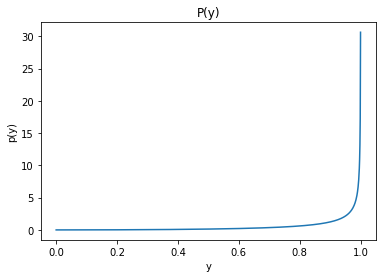

In [255]:
y=np.linspace(0,1,1001)
y=0.5*(y[1:]+y[:-1])

p=np.exp(-np.sqrt(-2*np.log(y))) * y / np.sqrt(-2*np.log(y)) 

plt.figure(1)
plt.title("P(y)")
plt.ylabel("p(y)")
plt.xlabel("y")
plt.plot(y,p)
plt.show()

But here is the problem. Since the Gaussian scales as $e^{-x^2/2}$ and the exponential as $e^{-x}$, we will not be able to find a Gaussian distribution that bounds the exponential distribution for all $x$ (notice how it tails off quickly as $y = e^{-x^2/2}$ goes to $0$ much fast than the exponential would). Due to the constraint that the initial distribution (Gaussian) must always be greater than the PDF we want to be sampling from (exponential), we find that the Gaussian fails to be a good bounding distribution.

For fun, we can still go through the motions and see how it fails. We will draw random samples from the box bounded by the maximum of this distribution. If they fall under the curve, we take them to be good samplings of our original distribution.

accept fraction is  0.0171359


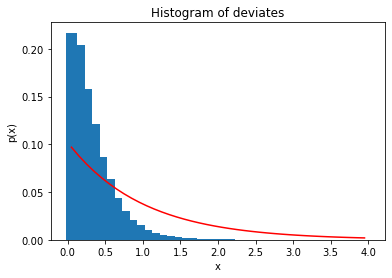

In [251]:
# now, we run the rejection algorithm
n=10000000
yy=np.random.rand(n) # random numbers between 0 and 1

# the prob. dist of these random points is
myp=np.exp(-np.sqrt(-2*np.log(yy))) * yy / np.sqrt(-2*np.log(yy))
# make the box
fac=1.01*p.max()
accept=(np.random.rand(n)*fac)<myp # accept or reject
print('accept fraction is ',np.mean(accept)) # print the fraction

# transform these into x values
y_use=yy[accept]
x_use=np.sqrt(1/y_use-1)

# make a histrogram 
aa,bb=np.histogram(x_use,np.linspace(0,4,41))

# center the bins
b_cent=0.5*(bb[1:]+bb[:-1])

# compute the theoretical prediction (just an exponential)
pred=np.exp(-b_cent)
pred=pred/pred.sum() # normalize it
aa=aa/aa.sum() # normalize the histogram too

# plot it
plt.figure(2)
plt.title("Histogram of deviates")
plt.ylabel("p(x)")
plt.xlabel("x")
plt.plot(b_cent,pred,c='r')
plt.bar(b_cent,aa,0.15)
plt.show()

Indeed, the sampling is erroneous.

Now for the Lorentzian. We have $x = \sqrt{1/y-1}$ and $|\frac{dx}{dy}| = \frac{1}{2y^2 \sqrt{1/y-1}}$. We can rest assured that the Lorentzian scales as $x^{-2}$ for large $x$, so the exponential scaling will always be smaller (unlike for the Gaussian). The Lorentzian has all the ingredients to be an adequate bounding distribution. Let's try it out:

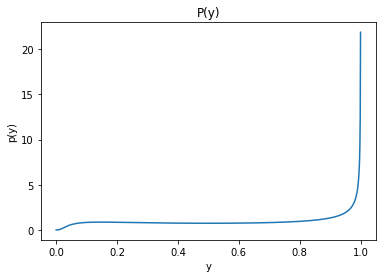

accept fraction is  0.0448435


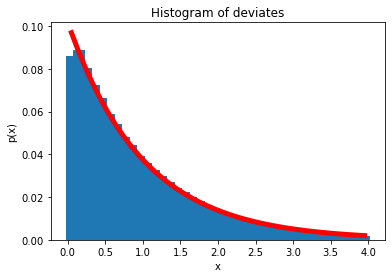

In [395]:
# make some y points
y=np.linspace(0,1,1001)
y=0.5*(y[1:]+y[:-1]) # center them

# compute p(y)
p=np.exp(-np.sqrt(1/y-1)) * 1/2 / (y**2 * np.sqrt(1/y-1))

# plot it 
plt.figure(1)
plt.title("P(y)")
plt.ylabel("p(y)")
plt.xlabel("y")
plt.plot(y,p)
plt.show()

# now, we run the rejection algorithm
n=10000000
yy=np.random.rand(n) # random numbers between 0 and 1

# the prob. dist of these random points is
myp=np.exp(-np.sqrt(1/yy-1)) * 1/2 / (yy**2 * np.sqrt(1/yy-1))

# make the box
fac=1.01*p.max()
accept=(np.random.rand(n)*fac)<myp # accept or reject
print('accept fraction is ',np.mean(accept)) # print the fraction

# transform these into x values
y_use=yy[accept]
x_use=np.sqrt(1/y_use-1)

# make a histrogram 
aa,bb=np.histogram(x_use,np.linspace(0,4,41))

# center the bins
b_cent=0.5*(bb[1:]+bb[:-1])

# compute the theoretical prediction (just an exponential)
pred=np.exp(-b_cent)
pred=pred/pred.sum() # normalize it
aa=aa/aa.sum() # normalize the histogram too

# plot it
plt.figure(2)
plt.title("Histogram of deviates")
plt.ylabel("p(x)")
plt.xlabel("x")
plt.plot(b_cent,pred,c='r',lw=5)
plt.bar(b_cent,aa,0.15)
plt.show()

We repeat the same procedure for the power law. We have $x = y^{1/(a-1)}$ and $|\frac{dx}{dy}| = \frac{1}{a-1} y^{1/(a-1)-1}$. Once again, we expect this to work since the behaviour scales as polynomial while our exponential PDF is exponential (of course). Therefore, we go through the same motions as before:

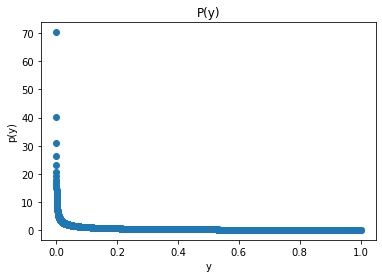

accept fraction is  0.0088714


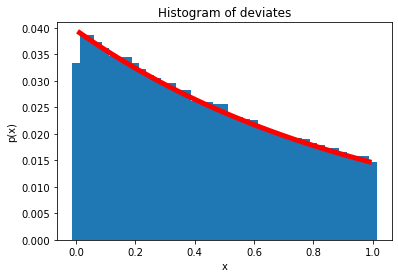

In [402]:
# make some y points
a = 3. # the powr law coefficient, for conreteness

# make some points between 0 and 1
y = np.linspace(0.000,1,10001)
y=0.5*(y[1:]+y[:-1]) # center them

# compute p(y)
p=np.exp(-y**(1/(a-1))) * 1/(a-1) * (y**(1/(a-1)-1))

# plot it 
plt.figure(1)
plt.title("P(y)")
plt.ylabel("p(y)")
plt.xlabel("y")
plt.scatter(y,p)
plt.show()

# now, we run the rejection algorithm
n=10000000
yy = np.random.rand(n) # random numbers between 0 and 1
# the prob. dist of these random points is
myp=np.exp(-yy**(1/(a-1))) * 1/(a-1) * (yy**(1/(a-1)-1))

# make the box
fac=1.01*p.max()
accept=(np.random.rand(n)*fac)<myp # accept or reject
print('accept fraction is ',np.mean(accept)) # print the fraction

# transform these into x values
y_use=yy[accept]
x_use=y_use**(1/(a-1))

# make a histrogram 
aa,bb=np.histogram(x_use,np.linspace(0,1,41))

# center the bins
b_cent=0.5*(bb[1:]+bb[:-1])

# compute the theoretical prediction (just an exponential)
pred=np.exp(-b_cent)
pred=pred/pred.sum() # normalize it
aa=aa/aa.sum() # normalize the histogram too

# plot it
plt.figure(2)
plt.title("Histogram of deviates")
plt.ylabel("p(x)")
plt.xlabel("x")
plt.plot(b_cent,pred,c='r',lw=5)
plt.bar(b_cent,aa,0.05)
plt.show()

We see that, once again, these agree quite well, though the acceptance rate of $.8$% is quite low. As we can tell, the efficieny (fraction of accepted deviates) is quite low in either the Lorentzian or power-law case. This is due to the high-tailed nature of $\tilde{p}(y)$ making it difficult to effectively sample and reject deviates in a box of uniform height. So, we can make it efficient to about $4$% in the Lorentzian case, and $0.8$% in the power-law case.

## Question 3

Taking $p(x) = e^{-x}$, together with the fact that $u$ runs from $0$ to $\sqrt{p(v/u)}$, we find our limits on $v$ by setting $u = \sqrt{p(v/u)}$. This yields $\boxed{v = -2u\log{u}}$ as our limit on $v$. Since the probability $p(v/u)$ is $0$ for $v/u < 0$, we need only sample in the positive quandrant of the $(u,v)$ plane.  

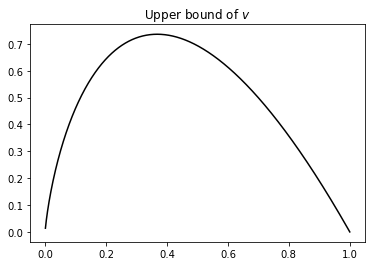

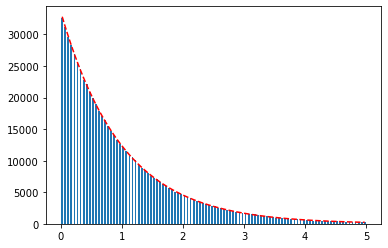

In [248]:
# make the u points
u=np.linspace(0,1,1001)
u=u[1:]

# set the v upper bound
v=-2*u*np.log(u)

# plot it
plt.figure(1)
plt.title(r"Upper bound of $v$")
plt.ylabel("v")
plt.xlabel("u")
plt.plot(u,v,'k') # we only care about positive v values
plt.show()

# ratio of uniform distributions
N=1000000
u=np.random.rand(N)
v=(np.random.rand(N))*v.max()*1.01 # just to be safe add some fudge
r=v/u # take the ratio
accept=u<np.exp(-r/2) # sample it with the sqrt of our prob. distribution
expon=r[accept] # accept it

# make a historgram
a,b=np.histogram(expon,np.linspace(0,5,101),density=False)
bb=0.5*(b[1:]+b[:-1])

# theoreotical prediction
pred = np.exp(-bb) * np.sum(accept) * (bb[2] -bb[1])

# plot it
plt.figure(2)
plt.title("Histogram of deviates")
plt.ylabel("p(x)")
plt.xlabel("x")
plt.bar(bb,a,0.03)
plt.plot(bb,pred,'r',ls='--')
plt.show()

As we can see, our results are in agreement with an exponential curve. To get the efficiency, simply count the `True`s in accept:

In [247]:
np.mean(accept)

0.673798

The efficiency is about $67$% of exponential deviates produced per uniform deviates (much better than our previous methods).